# Preparation

## Import Packages

# used to ignore "FutureWarnings"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
# data packages
import pandas as pd
import numpy as np

# preprocessing
from sklearn.preprocessing import StandardScaler

# splits and hyper paramater tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

## Import Data

In [22]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets

# peek at the head of data set 
pd.concat([X, y], axis=1).head()

# No preprocessing necessary in terms of cleaning. Data set is pre-cleaned.

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [671]:
unique_elements, counts = np.unique(y, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"Element {element}: {count} occurrences")

Element 0: 2788 occurrences
Element 1: 1813 occurrences


# Logistic Regression

## Pre-processing

In [26]:
# Standardize data for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## Hyper Parameter Tuning

In [29]:
# fix dimensions of y
y = y.to_numpy().ravel()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=47)
logreg = LogisticRegression()

# hyperparameter tuning with GridSearchCV
param_grid = [
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'max_iter': [2000, 3000, 5000]
    },
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1],
        'solver': ['saga'],
        'max_iter': [2000, 3000, 5000]
    }
]

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1],
                          'max_iter': [2000, 3000, 5000], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [0.001, 0.01, 0.1],
                          'max_iter': [2000, 3000, 5000],
                          'penalty': ['l1', 'l2'], 'solver': ['saga']}],
             scoring='precision')

In [96]:
# Get tuned paramaters
print(f'{grid_search.best_params_=}')
print(f'{grid_search.best_score_=}')

grid_search.best_params_={'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
grid_search.best_score_=0.9220935797549474


## Train and Test Model with tuned hyper parameters

In [853]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=47)

# logistic regression with tuned parameters
logreg = LogisticRegression(C=0.001, max_iter=2000, solver='saga', penalty='l2')

# fit the data to the model
logreg.fit(X_train, y_train)

# get predictions on testing and training sets
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

# test overfitting
print(f'Training precision: {precision_score(y_train, y_pred_train)}')
print(f'Testing precision: {precision_score(y_test, y_pred)}')

Training precision: 0.9256342957130359
Testing precision: 0.9379310344827586


### Visualize coefficients

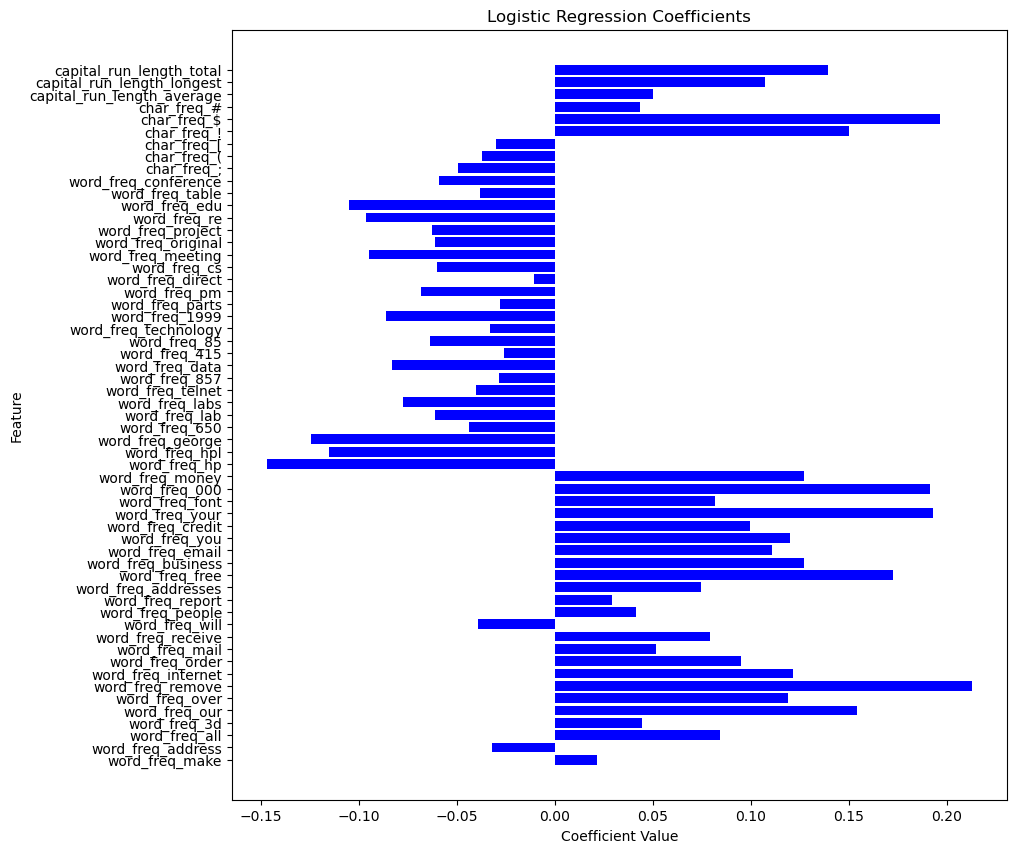

In [817]:
coefficients = logreg.coef_[0]
features = X.columns 

plt.figure(figsize=(10, 10))
plt.barh(features, coefficients, color='b')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

# Decision Tree

## Hyper-Parameter tuning

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
dtc = DecisionTreeClassifier()

param_grid = [
    {
        'max_depth': [3, 5, 10, 30, 50],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'ccp_alpha': [0.0, 0.0001, 0.001, 0.005, 0.01, 0.05],
        'splitter': ['best', 'random'],
        'class_weight': ['balanced', None],
        'min_samples_split': [2, 4, 6],
    }
]
        
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.0, 0.0001, 0.001, 0.005, 0.01, 0.05],
                          'class_weight': ['balanced', None],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 10, 30, 50],
                          'max_features': ['auto', 'sqrt', 'log2', None],
                          'min_samples_split': [2, 4, 6],
                          'splitter': ['best', 'random']}],
             scoring='precision')

In [186]:
# Get tuned paramaters
print(f'{grid_search.best_params_=}')
print(f'{grid_search.best_score_=}')

grid_search.best_params_={'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
grid_search.best_score_=0.9217575092568564


## Train and Test Model with tuned hyper parameters

In [855]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
# Decision Tree Classifier Instantiation
dtc = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5, max_features=None, max_leaf_nodes=20, min_samples_split=6, splitter='best'
)
# fit the data to the model
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=20,
                       min_samples_split=6)

In [857]:
# Training and testing predictions
y_pred_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)

In [859]:
print(f'Training precision: {precision_score(y_train, y_pred_train)}')
print(f'Testing precision: {precision_score(y_test, y_pred)}\n')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')

Training precision: 0.9173431734317343
Testing precision: 0.9196675900277008

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       539
           1       0.92      0.87      0.89       382

    accuracy                           0.91       921
   macro avg       0.92      0.91      0.91       921
weighted avg       0.91      0.91      0.91       921

Confusion Matrix:
 [[510  29]
 [ 50 332]]


In [861]:
# Get feature importance
feature_importance = pd.DataFrame(dtc.feature_importances_, index=X.columns)

# Displays with values of 0.0 importance dropped
feature_importance[(feature_importance != 0).all(axis=1)]

,0
word_freq_our,0.015210
word_freq_remove,0.091157
word_freq_free,0.029697
word_freq_email,0.008914
word_freq_hp,0.104138
word_freq_george,0.052114
word_freq_edu,0.026901
char_freq_!,0.207322
char_freq_$,0.390864
capital_run_length_average,0.067049


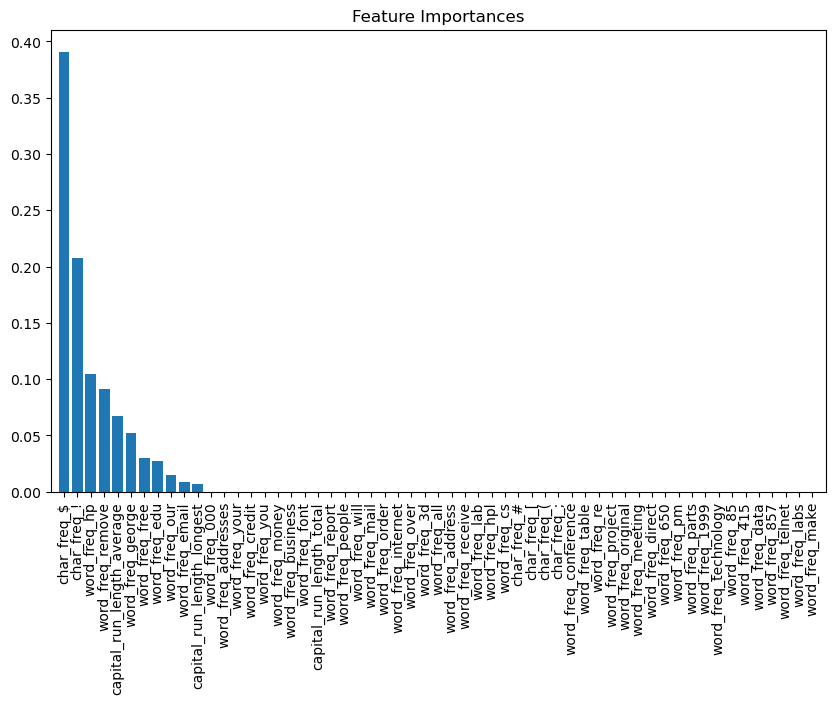

In [869]:
import numpy as np
import matplotlib.pyplot as plt

importances = dtc.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns 

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Random Forest

## Hyperparameter tuning

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
rfc = RandomForestClassifier()

param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 4, 6],
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': [50, 80, None],
        'class_weight': ['balanced', 'balanced_subsample'],
    }
]
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1) 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [10, 20, None],
                          'max_features': ['sqrt', 'log2', None],
                          'max_leaf_nodes': [50, 80, None],
                          'min_samples_split': [2, 4, 6]}],
             scoring='precision')

In [294]:
print(f'{grid_search.best_params_=}')
print(f'{grid_search.best_score_=}')

grid_search.best_params_={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_split': 2}
grid_search.best_score_=0.9600656527466673


## Train and Test Model with tuned hyper parameters

In [842]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Random Forest Classifier instantiation
rfc = RandomForestClassifier(random_state=158327, class_weight='balanced_subsample', min_samples_leaf=2, criterion='entropy', max_features='log2', min_samples_split=2)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='log2', min_samples_leaf=2,
                       random_state=158327)

In [843]:
y_pred_train = rfc.predict(X_train)
y_pred = rfc.predict(X_test)


print(f'Training precision: {precision_score(y_train, y_pred_train)}')
print(f'Testing precision: {precision_score(y_test, y_pred)}\n')
print(f'Classification Report Training:\n {classification_report(y_train, y_pred_train)}')
print(f'Classification Report Testing:\n {classification_report(y_test, y_pred)}')

Training precision: 0.9893767705382436
Testing precision: 0.952

Classification Report Training:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2249
           1       0.99      0.98      0.98      1431

    accuracy                           0.99      3680
   macro avg       0.99      0.98      0.99      3680
weighted avg       0.99      0.99      0.99      3680

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       539
           1       0.95      0.93      0.94       382

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



In [846]:
# Get feature importance
feature_importance = pd.DataFrame(dtc.feature_importances_, index=X.columns)

# Displays with values of 0.0 importance dropped
feature_importance[(feature_importance != 0).all(axis=1)]

,0
word_freq_our,0.015210
word_freq_remove,0.100071
word_freq_free,0.029697
word_freq_hp,0.104138
word_freq_george,0.052114
word_freq_edu,0.026901
char_freq_!,0.207322
char_freq_$,0.390864
capital_run_length_average,0.067049
capital_run_length_longest,0.006633


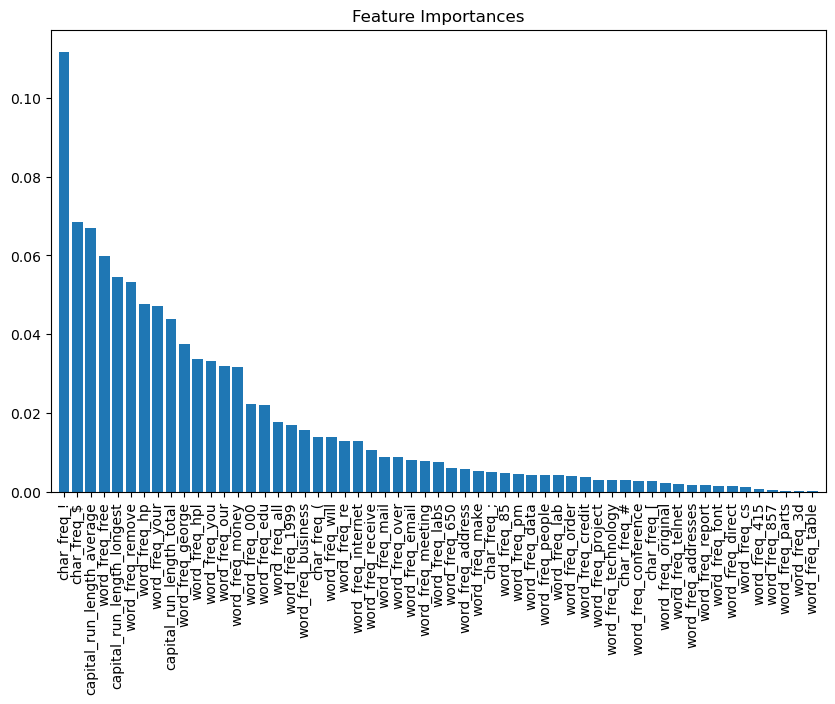

In [871]:
import numpy as np
import matplotlib.pyplot as plt


importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# XGBoost

In [803]:
# XGBoost doesnt support 
X_scaled.rename(columns={'char_freq_;': 'freq_semicolon', 'char_freq_(': 'freq_perenth', 'char_freq_[': 'freq_bracket', 'char_freq_!': 'freq_exclamation', 'char_freq_$': 'freq_money_sign', 'char_freq_#': 'freq_hashtag'}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=47)
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

print(f'Classification Report Training:\n {classification_report(y_train, y_pred_train)}')
print(f'Classification Report Testing:\n {classification_report(y_test, y_pred)}')

Classification Report Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2249
           1       1.00      0.99      1.00      1431

    accuracy                           1.00      3680
   macro avg       1.00      1.00      1.00      3680
weighted avg       1.00      1.00      1.00      3680

Classification Report Testing:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       539
           1       0.94      0.95      0.94       382

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921

